##**Data** **Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
import time
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

train = pd.read_csv("data/UNSW_NB15_training-set.csv")
test  = pd.read_csv("data/UNSW_NB15_testing-set.csv")

drop_cols = ["id", "attack_cat"]
X_train_full = train.drop(columns=drop_cols + ["label"])
y_train_full = train["label"]

X_test = test.drop(columns=drop_cols + ["label"])
y_test = test["label"]

cat_cols = X_train_full.select_dtypes(include="object").columns

encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

X_train_full[cat_cols] = encoder.fit_transform(X_train_full[cat_cols])
X_test[cat_cols]  = encoder.transform(X_test[cat_cols])



##**RF-SVM**

In [ ]:
rf_svm_rf  = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_svm_rf .fit(X_train_full, y_train_full)

X_train_rfprob  = rf_svm_rf .predict_proba(X_train_full)
X_test_rfprob   = rf_svm_rf .predict_proba(X_test)

svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train_rfprob , y_train_full)
end = time.time()

svm_preds = svm.predict(X_test_rfprob  )



In [ ]:
svm_probs = svm.predict_proba(X_test_rfprob)[:, 1]

##**RNN**

In [ ]:
X_train_np = X_train_full.to_numpy()
X_test_np  = X_test.to_numpy()

X_train_rnn = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_rnn  = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

y_train_rnn = y_train_full.to_numpy().astype(int)
y_test_rnn  = y_test.to_numpy().astype(int)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Bidirectional(
        SimpleRNN(
            units=64,
            activation="tanh",
            return_sequences=False
        ),
        input_shape=(X_train_rnn.shape[1], 1)
    ),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_rnn,
    y_train_full,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)




/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8760 - loss: 0.2742 - val_accuracy: 0.9890 - val_loss: 0.0410
Epoch 2/5
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9308 - loss: 0.1469 - val_accuracy: 0.9970 - val_loss: 0.0200
Epoch 3/5
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9327 - loss: 0.1407 - val_accuracy: 0.9867 - val_loss: 0.0361
Epoch 4/5
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9355 - loss: 0.1346 - val_accuracy: 0.9890 - val_loss: 0.0291
Epoch 5/5
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9344 - loss: 0.1355 - val_accuracy: 0.9865 - val_loss: 0.0318


In [ ]:
rnn_y_prob = model.predict(X_test_rnn).ravel()
rnn_y_pred = (rnn_y_prob >= 0.5).astype(int)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


##**IDRF**

In [ ]:
cat_cols = X_train_full.select_dtypes(include="object").columns

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train_full[cat_cols] = encoder.fit_transform(X_train_full[cat_cols])
X_test[cat_cols]       = encoder.transform(X_test[cat_cols])


In [ ]:
scaler = MinMaxScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test       = scaler.transform(X_test)

In [ ]:
X_train, X_prune, y_train, y_prune = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=150,
    max_features=0.3,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=0.3, n_estimators=150, n_jobs=-1,
                       random_state=42)

In [ ]:

importances = rf.feature_importances_
importances /= importances.sum()

alpha = np.median(importances)
Fs = np.where(importances <= alpha)[0]
Fw = np.where(importances > alpha)[0]

all_features = np.arange(X_train.shape[1])


In [ ]:

n_trees = 150
trees = []

for _ in range(n_trees):

    if len(Fs) == 0 or len(Fw) == 0:
        feat_idx = np.random.choice(
            all_features,
            size=int(0.3 * len(all_features)),
            replace=False
        )
    else:
        feat_idx = np.concatenate([
            np.random.choice(Fw, size=max(1, len(Fw)//2), replace=False),
            np.random.choice(Fs, size=max(1, len(Fs)//2), replace=False)
        ])

    tree = DecisionTreeClassifier(
        max_depth=None,
        min_samples_leaf=1,
        random_state=random.randint(0, 10000)
    )
    tree.fit(X_train[:, feat_idx], y_train)
    trees.append((tree, feat_idx))


In [ ]:

def tree_contribution(tree, feats, Xp, yp):
    preds = tree.predict(Xp[:, feats])
    score = 0
    for p, y in zip(preds, yp):
        if p == y and y == 1:
            score += 2
        elif p == y and y == 0:
            score += 1
        else:
            score -= 2
    return score


In [ ]:
scores = [
    (i, tree_contribution(t, f, X_prune, y_prune))
    for i, (t, f) in enumerate(trees)
]

scores.sort(key=lambda x: x[1], reverse=True)

sorted_trees  = [trees[i] for i, _ in scores]
sorted_scores = [s for _, s in scores]

In [ ]:
best_acc = 0
best_ensemble = None
best_scores = None
slide = 0

prune_accuracies = []
tree_counts = []

current_trees = sorted_trees.copy()
current_scores = sorted_scores.copy()

while len(current_trees) > 10:

    preds = np.array([
        t.predict(X_prune[:, f])
        for t, f in current_trees
    ])

    prune_pred = (preds.mean(axis=0) >= 0.5).astype(int)
    acc = accuracy_score(y_prune, prune_pred)

    prune_accuracies.append(acc)
    tree_counts.append(len(current_trees))

    if acc > best_acc:
        best_acc = acc
        best_ensemble = current_trees.copy()
        best_scores = current_scores.copy()
        slide = 0
    else:
        slide += 1

    if slide == 3:
        break

    current_trees.pop()
    current_scores.pop()

print(f"Best Prune Accuracy (ASW): {best_acc*100:.2f}%")

Best Prune Accuracy (ASW): 96.18%


In [ ]:
weights = np.array(best_scores, dtype=float)
weights = weights - weights.min() + 1e-6
weights = weights / weights.sum()

prune_probs = np.zeros(len(X_prune))
for (tree, f), w in zip(best_ensemble, weights):
    prune_probs += w * tree.predict(X_prune[:, f])

In [ ]:
fpr, tpr, thresholds = roc_curve(y_prune, prune_probs)
best_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]

print("Chosen decision threshold:", best_threshold)

Chosen decision threshold: 0.663543304384194


In [ ]:
test_probs = np.zeros(len(X_test))
for (tree, f), w in zip(best_ensemble, weights):
    test_probs += w * tree.predict(X_test[:, f])

final_test_pred = (test_probs >= best_threshold).astype(int)
final_test_acc = accuracy_score(y_test, final_test_pred)

##**Classification** **Report**

In [ ]:
print("===== IDRandom-Forest (IDRF) Classification Report =====")
print(classification_report(
    y_test,
    final_test_pred,
    target_names=["Normal", "Attack"]
))


===== IDRandom-Forest (IDRF) Classification Report =====
              precision    recall  f1-score   support

      Normal       0.94      0.83      0.88     37000
      Attack       0.88      0.95      0.91     45332

    accuracy                           0.90     82332
   macro avg       0.91      0.89      0.90     82332
weighted avg       0.90      0.90      0.90     82332



In [ ]:
print("===== RF–SVM Classification Report =====")
print(classification_report(
    y_test,
    svm_preds,
    target_names=["Normal", "Attack"]
))


===== RF–SVM Classification Report =====
              precision    recall  f1-score   support

      Normal       0.98      0.73      0.84     37000
      Attack       0.82      0.99      0.90     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332



In [ ]:
print("===== GA-BiIndRNN (BiIndRNN) Classification Report =====")
print(classification_report(
    y_test,
    rnn_y_pred,
    target_names=["Normal", "Attack"]
))


===== GA-BiIndRNN (BiIndRNN) Classification Report =====
              precision    recall  f1-score   support

      Normal       0.97      0.76      0.85     37000
      Attack       0.83      0.98      0.90     45332

    accuracy                           0.88     82332
   macro avg       0.90      0.87      0.88     82332
weighted avg       0.90      0.88      0.88     82332



In [ ]:
idrf_acc = accuracy_score(y_test, final_test_pred)
print(f"IDRandom-Forest (IDRF) Accuracy: {idrf_acc*100:.2f}%")


rf_svm_acc = accuracy_score(y_test, svm_preds)
print(f"RF–SVM Accuracy: {rf_svm_acc*100:.2f}%")


rnn_acc = accuracy_score(y_test, rnn_y_pred)
print(f"GA-BiIndRNN (BiIndRNN) Accuracy: {rnn_acc*100:.2f}%")




IDRandom-Forest (IDRF) Accuracy: 90.04%
RF–SVM Accuracy: 87.28%
GA-BiIndRNN (BiIndRNN) Accuracy: 88.24%


##**Confusion** **Matrix**

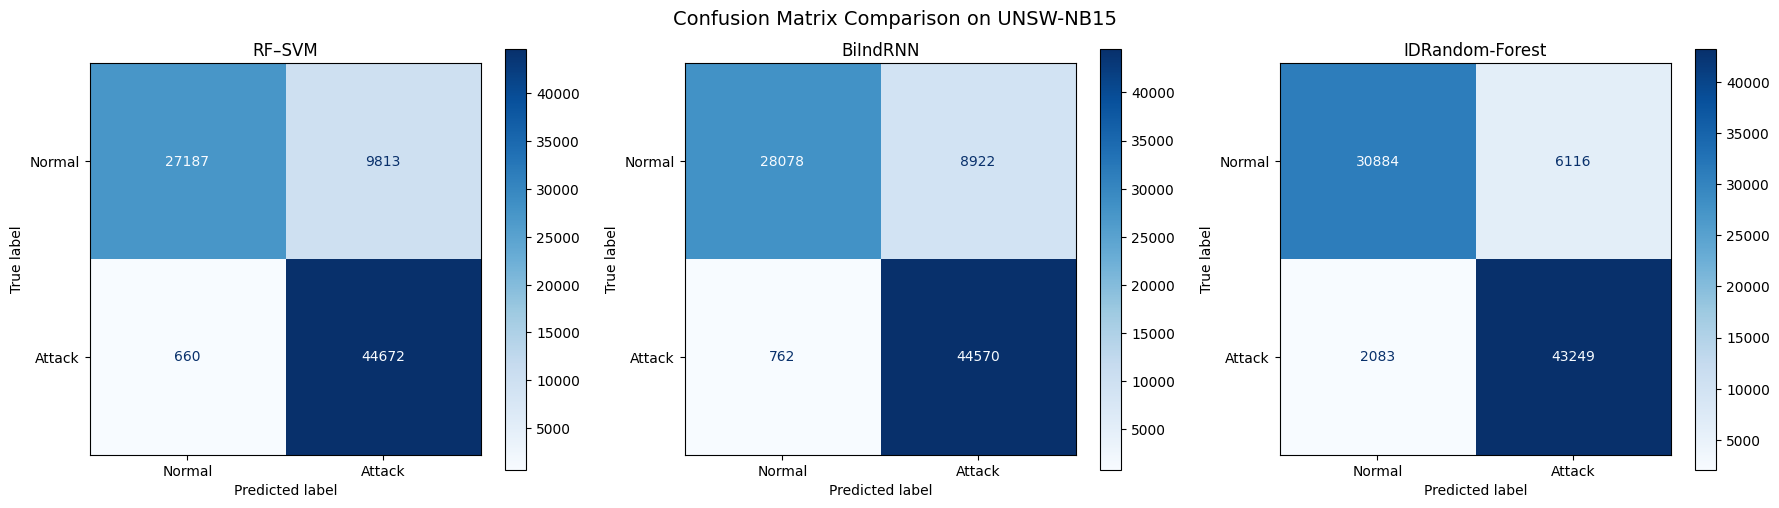

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))


cm_rf_svm = confusion_matrix(y_test, svm_preds)
disp1 = ConfusionMatrixDisplay(cm_rf_svm, display_labels=["Normal", "Attack"])
disp1.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title("RF–SVM")


cm_rnn = confusion_matrix(y_test, rnn_y_pred)
disp2 = ConfusionMatrixDisplay(cm_rnn, display_labels=["Normal", "Attack"])
disp2.plot(ax=axes[1], cmap="Blues", values_format="d")
axes[1].set_title("BiIndRNN")

cm_idrf = confusion_matrix(y_test, final_test_pred)
disp3 = ConfusionMatrixDisplay(cm_idrf, display_labels=["Normal", "Attack"])
disp3.plot(ax=axes[2], cmap="Blues", values_format="d")
axes[2].set_title("IDRandom-Forest")

plt.suptitle("Confusion Matrix Comparison on UNSW-NB15", fontsize=14)
plt.tight_layout()
plt.show()


##**ROC Curve**

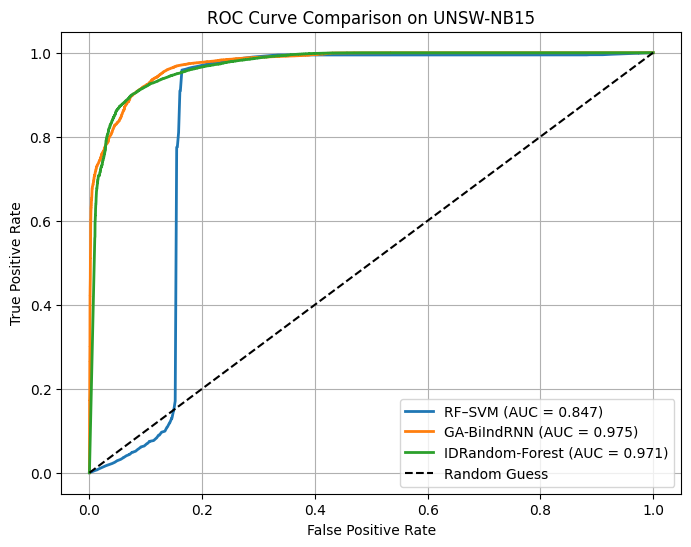

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(y_test, svm_probs)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_rnn, tpr_rnn, _ = roc_curve(y_test, rnn_y_prob)
auc_rnn = auc(fpr_rnn, tpr_rnn)

fpr_idrf, tpr_idrf, _ = roc_curve(y_test, test_probs)
auc_idrf = auc(fpr_idrf, tpr_idrf)

plt.figure(figsize=(8, 6))

plt.plot(fpr_rf, tpr_rf, label=f"RF–SVM (AUC = {auc_rf:.3f})", linewidth=2)
plt.plot(fpr_rnn, tpr_rnn, label=f"GA-BiIndRNN (AUC = {auc_rnn:.3f})", linewidth=2)
plt.plot(fpr_idrf, tpr_idrf, label=f"IDRandom-Forest (AUC = {auc_idrf:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison on UNSW-NB15")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
start = time.time()
rf_probs = rf_svm_rf.predict_proba(X_test)
svm.predict(rf_probs)
rf_svm_test_time = time.time() - start
print(f"RF–SVM Testing Time (seconds): {rf_svm_test_time:.4f}")


start = time.time()
model.predict(X_test_rnn, verbose=0)
rnn_test_time = time.time() - start
print(f"GA-BiIndRNN Testing Time (sec): {rnn_test_time:.4f}")


X_test_np = X_test
start = time.time()
_ = np.array([
    t.predict(X_test_np[:, f])
    for t, f in best_ensemble
])
idrf_test_time = time.time() - start
print(f"IDRF Testing Time (sec): {idrf_test_time:.4f}")



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RF–SVM Testing Time (seconds): 6.2941
GA-BiIndRNN Testing Time (sec): 6.4107
IDRF Testing Time (sec): 1.5927


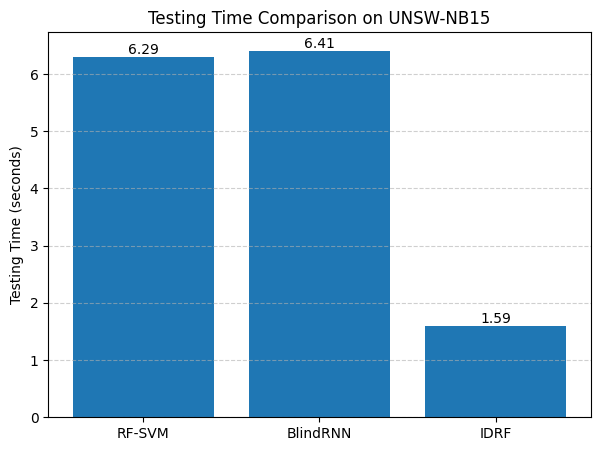

In [ ]:
import matplotlib.pyplot as plt

models = ["RF-SVM", "BlindRNN", "IDRF"]
times = [rf_svm_test_time, rnn_test_time, idrf_test_time]

plt.figure(figsize=(7, 5))
bars = plt.bar(models, times)

plt.ylabel("Testing Time (seconds)")
plt.title("Testing Time Comparison on UNSW-NB15")
plt.grid(axis="y", linestyle="--", alpha=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval,
             f"{yval:.2f}",
             ha="center",
             va="bottom")

plt.show()
